<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0408_For_Non_stopwordsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount, Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os, re, string, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, concatenate, add
from tensorflow.keras.layers import Conv1D, GRU, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0407-add-len-translated_train.csv')

In [ ]:
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0407-add-len-translated_test.csv')

----

# Preprocessing Augumented data

## English -> French -> English

In [ ]:
train_fr = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_fr.csv')
train_fr['2-trans'] = train_fr['comment_text']
train_fr.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,2-trans
0,0000997932d777bf,Explanation\nWhy have the changes made under m...,0,0,0,0,0,0,Explanation\nWhy have the changes made under m...


In [ ]:
# 1. Capitalization / Lower case
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
!pip install contractions
import contractions
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: x.lower())
# # Remove stopwords
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Find zero len comment
zerolen_t = list()
num = 0
for i in train_fr['2-trans']:
  if not re.search('\S',i):
    zerolen_t.append(num)
  num += 1
print(len(zerolen_t))  # 전처리 되어서 ''된 갯수 

16


In [ ]:
# 기존 comment_text 로 교체
for i in zerolen_t:
  train_fr['2-trans'][i] = train_fr['comment_text'][i] # 기본 데이터로 대체

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## English -> Deutsch -> English

In [ ]:
train_de = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_de.csv')
train_de['2-trans'] = train_de['comment_text']
train_de.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,2-trans
0,0000997932d777bf,explanation\nWhy have the edits been undone un...,0,0,0,0,0,0,explanation\nWhy have the edits been undone un...


In [ ]:
# 1. Capitalization / Lower case
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
train_de['2-trans'] = train_de['2-trans'].apply(lambda x: x.lower())
# # Remove stopwords
# train_de['2-trans'] = train_de['2-trans'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Find zero len comment
zerolen_t = list()
num = 0
for i in train_de['2-trans']:
  if not re.search('\S',i):
    zerolen_t.append(num)
  num += 1
print(len(zerolen_t))  # 전처리 되어서 ''된 갯수 

# 기존 comment_text 로 교체
for i in zerolen_t:
  train_de['2-trans'][i] = train_de['comment_text'][i] # 기본 데이터로 대체

22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## English -> Espanol -> English

In [ ]:
train_es = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_es.csv')
train_es['2-trans'] = train_es['comment_text']
train_es.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,2-trans
0,0000997932d777bf,Explanation\nWhy were the changes made under m...,0,0,0,0,0,0,Explanation\nWhy were the changes made under m...


In [ ]:
# 1. Capitalization / Lower case
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
train_es['2-trans'] = train_es['2-trans'].apply(lambda x: x.lower())
# # Remove stopwords
# train_es['2-trans'] = train_es['2-trans'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Find zero len comment
zerolen_t = list()
num = 0
for i in train_es['2-trans']:
  if not re.search('\S',i):
    zerolen_t.append(num)
  num += 1
print(len(zerolen_t))  # 전처리 되어서 ''된 갯수 

# 기존 comment_text 로 교체
for i in zerolen_t:
  train_es['2-trans'][i] = train_es['comment_text'][i] # 기본 데이터로 대체

14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Train Data Augumentation

In [ ]:
toxic_train = pd.concat([train_de,train_es,train_fr])
toxic_train.shape

(478713, 9)

In [ ]:
del train_de, train_es, train_fr

In [ ]:
train_augumented = pd.concat([toxic_train, train])

from sklearn.utils import shuffle
train_augumented = shuffle(train_augumented)

In [ ]:
train_augumented.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,2-trans,1-pre,len-2-trans
75166,c91d6d6da368cd3a,"""== Tech News: 2014-44 ==\n\nLatest tech news ...",0,0,0,0,0,0,tech news 2014 44 latest tech news wikimedia t...,tech news 2014 44 latest tech news wikimedia t...,126.0
34408,5be585ffe22a67c9,I thought the page of the unit's feud was kool...,0,0,0,0,0,0,i thought the page of the unit s feud was kool...,NaN,NaN
6411,112062ec8681265b,""":::There was actually a (technically if not a...",0,0,0,0,0,0,actually technically aesthetically valid reaso...,actually technically aesthetically valid reaso...,28.0
114486,6456e110dd2fa62f,"""\n\nMy god, you are stupidity incarnate. HOW...",1,0,1,0,1,0,god stupidity incarnate fuck picture causing s...,god stupidity incarnate fuck picture causing s...,26.0


In [ ]:
train_augumented.shape

(638284, 11)

# New Train Data

In [ ]:
train_augumented.to_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0408-yes-stopwords.csv',index=False)

In [ ]:
train_augumented = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0408-yes-stopwords.csv')

-----------------------

# Tokenization

In [ ]:
list_sentences_train = train_augumented['2-trans'] # (638284,)
list_sentences_test = test['2-trans'] # (153164,)

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

206276

# Padding

In [ ]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (638284, 50)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 50)

X_t.shape

(638284, 50)

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (159571, 6)
y.shape

(638284, 6)

# Pretrained-Embedding-matrix

In [ ]:
embedding_dict = dict()
f = open('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/glove.twitter.27B.200d.txt/glove.twitter.27B.200d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 200
    embedding_dict[word] = word_vector_arr
f.close()
print('There are %s Embedding Vectors\n' % len(embedding_dict))

print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200)) # will delete first row

for word, i in tokenizer.word_index.items(): 
    temp = embedding_dict.get(word) 
    if temp is not None:
        embedding_matrix[i] = temp 

print(embedding_matrix.shape)
embedding_matrix = np.delete(embedding_matrix,0,axis=0) # delete first row
print(embedding_matrix.shape)

There are 1193514 Embedding Vectors

[-6.4748e-01 -3.7296e-01 -3.6128e-01  7.9975e-01 -2.1890e-01  7.6152e-01
 -7.3698e-02  2.2635e-01 -7.5429e-02  6.3600e-01 -6.5914e-01 -5.1787e-01
 -6.4411e-02 -3.0796e-01  4.4071e-01  1.4543e-01 -9.9792e-02 -2.3253e-01
  2.0882e-01 -9.3256e-02 -2.9659e-01 -1.6643e-01 -1.3184e-01 -5.5247e-01
 -6.0625e-01  9.6745e-01  3.8410e-01 -1.4236e-02  2.8774e-01  7.5652e-01
  1.1552e-01 -4.9894e-01 -9.2585e-02 -6.7708e-02  3.1373e-01  5.6426e-01
  1.9797e-01  4.0703e-02  2.7106e-01 -3.3045e-01  3.9652e-01  1.3718e-01
  5.0194e-01  3.7811e-01  2.9139e-01  2.6001e-01  2.9927e-01  3.6737e-01
  1.0638e-01  3.7086e-01  2.3767e-02  6.4266e-01 -2.4067e-01 -3.1749e-01
 -3.4070e-01  9.3053e-01  1.8900e-01 -2.7260e-01 -3.5132e-01  1.4086e-01
 -1.6232e-01  8.7983e-03 -8.7401e-02 -1.2887e-01  2.5303e-01  9.0737e-01
 -3.3149e-01  5.8059e-02 -2.3855e-01  3.5351e-01 -3.8560e-01 -4.6745e-01
 -2.2487e-01 -1.9058e-01  3.4685e-02  4.1231e-01  9.3602e-02  2.0409e-01
 -2.4806e-01  

In [ ]:
np.save('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0408-yes-stopwords-200d-pretrained-embed-Glove.npy',embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0408-yes-stopwords-200d-pretrained-embed-Glove.npy')
embedding_matrix

array([[ 0.49349999,  0.35698   ,  0.66068   , ...,  0.17705999,
        -0.53694999, -0.29699001],
       [ 0.61773998,  0.21046001,  0.52697998, ..., -0.011269  ,
        -0.52165002,  0.093783  ],
       [-0.0076446 , -0.089557  ,  0.32510999, ...,  0.17766   ,
        -0.031884  , -0.22815999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54215997, -0.56734002, -0.078547  , ...,  0.22057   ,
        -0.32414001, -0.12032   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Model

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=50
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Conv1D(64, 3, padding='valid', kernel_initializer='glorot_uniform')(x)
avg_pool = GlobalMaxPooling1D()(x)
max_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dense(128, activation="relu")(conc)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 200)      41255200    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 50, 200)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      253440      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/040 8-yes-stopwords-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 10
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/10
4488/4488 [==============================] - 1586s 352ms/step - loss: 0.0929 - accuracy: 0.9210 - val_loss: 0.0566 - val_accuracy: 0.9938

Epoch 00001: val_loss improved from inf to 0.05655, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0408-yes-stopwords-pretrained-embed-Glove.hdf5
Epoch 2/10
4488/4488 [==============================] - 1615s 360ms/step - loss: 0.0573 - accuracy: 0.9895 - val_loss: 0.0547 - val_accuracy: 0.9939

Epoch 00002: val_loss improved from 0.05655 to 0.05470, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0408-yes-stopwords-pretrained-embed-Glove.hdf5
Epoch 3/10
4488/4488 [==============================] - 1609s 359ms/step - loss: 0.0520 - accuracy: 0.9857 - val_loss: 0.0492 - val_accuracy: 0.9938

Epoch 00003: val_loss improved from 0.05470 to 0.04922, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0408-yes-stopwords-pretrained-embed-Glove.hdf5
Epoch 4/10
4488/4488 [=======

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0408-yes-stopwords-pretrained-embed-Glove.csv", index=False)

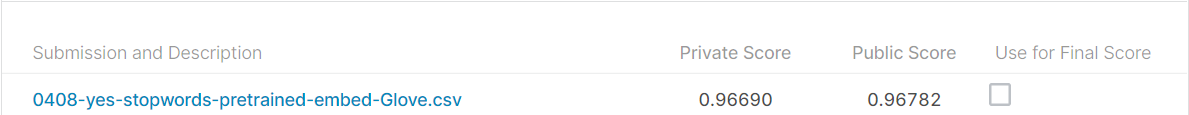